# Project 4b - Image Warping and Mosaicing

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from harris import get_harris_corners, dist2

## Interest Point Detector

In [2]:
# Load images and points
image_left = plt.imread('../data/IMG_8405.jpeg')
image_right = plt.imread('../data/IMG_8406.jpeg')

# make panoramal left b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

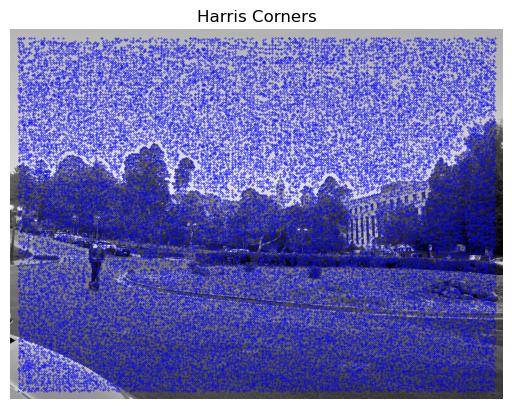

In [3]:
# Display Harris corners
plt.imshow(image_left_gray, cmap='gray')
plt.scatter(coords_left[1], coords_left[0], c='b', s=0.1)  # coords[1] for x, coords[0] for y
plt.title('Harris Corners')
plt.axis('off')
plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners, h, num_points=500, c_robust=0.9):
    """
    Adaptive Non-Maximal Suppression following the approach outlined.
    
    :param corners: (2, n) array of corner coordinates (ys, xs).
    :param h: Harris response values of the image.
    :param num_points: Number of points to retain after ANMS.
    :param c_robust: Constant used in suppression condition (default = 0.9).
    :return: Array of suppressed corner coordinates.
    """
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    # Return the top 'num_points' corners
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

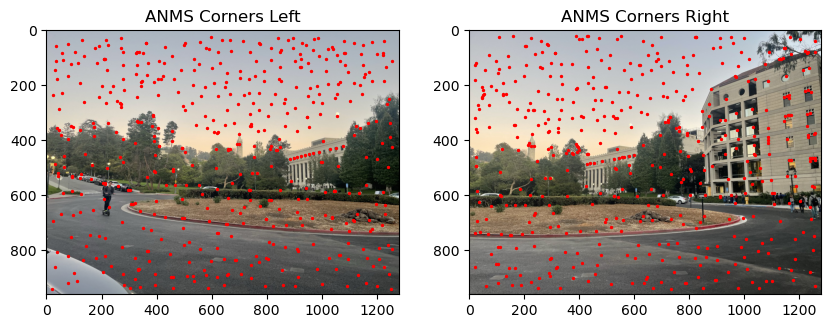

In [18]:
# Display ANMS corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_left, cmap='gray')
plt.scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
plt.title('ANMS Corners Left')

plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
plt.title('ANMS Corners Right')

plt.show()

## Feature Descriptor extraction

In [6]:
def extract_feature_descriptors(im, coords, patch_size=8, window_size=40, spacing=5):
    """
    Extracts bias/gain-normalized 8x8 color feature descriptors from a larger 40x40 window 
    around each interest point for each of the three color channels (R, G, B).
    
    Parameters:
    im (HxWx3 array): Colored image (RGB) from which to extract features.
    coords (2xN array): Coordinates of interest points (ys, xs).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    window_size (int): Size of the larger window from which the 8x8 patch is sampled (default is 40x40).
    spacing (int): Pixel spacing between samples for the 8x8 patch (default is 5).
    
    Returns:
    descriptors (N x 192 array): Normalized color feature descriptors for each interest point.
    """
    half_window = window_size // 2
    half_patch = patch_size // 2
    descriptors = []

    # Loop over each point
    for y, x in coords.T:
        # Check for edge cases (skip points near the edges)
        if (y - half_window < 0 or y + half_window >= im.shape[0] or 
            x - half_window < 0 or x + half_window >= im.shape[1]):
            continue

        # Initialize an empty list to store the descriptor for each channel
        descriptor_channels = []
        
        # Loop over each channel (R, G, B)
        for channel in range(3):
            # Extract the 40x40 window for the current channel
            window = im[y-half_window:y+half_window, x-half_window:x+half_window, channel]

            # Blur the window to reduce aliasing
            window = gaussian_filter(window, sigma=1)

            # Sample an 8x8 patch from the window with spacing
            patch = window[::spacing, ::spacing][:patch_size, :patch_size]

            # Normalize the patch (bias/gain normalization)
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)
            if patch_std > 0:
                patch = (patch - patch_mean) / patch_std

            # Flatten the patch into a vector and store it
            descriptor_channels.append(patch.flatten())

        # Concatenate descriptors from all three channels to form a single vector
        descriptor = np.concatenate(descriptor_channels)
        descriptors.append(descriptor)

    return np.array(descriptors)

descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

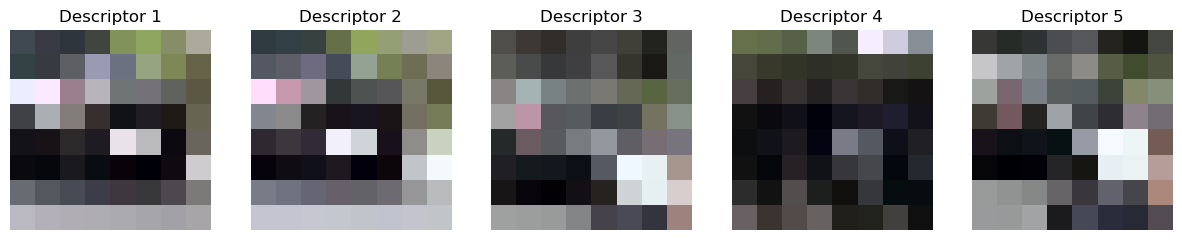

In [41]:
def visualize_descriptors(descriptors, num_descriptors=5, patch_size=8):
    """
    Visualizes the first few descriptors as RGB images.
    
    Parameters:
    descriptors (N x 192 array): Color feature descriptors.
    num_descriptors (int): Number of descriptors to visualize (default is 5).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    """
    fig, axes = plt.subplots(1, num_descriptors, figsize=(15, 5))
    
    for i in range(num_descriptors):
        descriptor = descriptors[i]
        
        # Reshape the descriptor into three 8x8 patches for R, G, B channels
        patch_r = descriptor[:patch_size*patch_size].reshape((patch_size, patch_size))
        patch_g = descriptor[patch_size*patch_size:2*patch_size*patch_size].reshape((patch_size, patch_size))
        patch_b = descriptor[2*patch_size*patch_size:].reshape((patch_size, patch_size))
        
        # Combine the patches into a single 8x8x3 RGB image
        patch_rgb = np.stack((patch_r, patch_g, patch_b), axis=-1)
        
        # Normalize the RGB image to [0, 1] for visualization
        patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())
        
        # Display the RGB image
        axes[i].imshow(patch_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'Descriptor {i+1}')
    
    plt.show()

visualize_descriptors(descriptors_left, num_descriptors=5)

## Feature Matching

In [31]:
def match_features(descriptors1, descriptors2, ratio_threshold=0.8):
    """
    Matches color feature descriptors from two sets using Lowe's ratio test, enforcing one-to-one matching.
    
    Parameters:
    descriptors1 (N1 x 192 array): Color feature descriptors from the first image.
    descriptors2 (N2 x 192 array): Color feature descriptors from the second image.
    ratio_threshold (float): Threshold for Lowe's ratio test (default is 0.8).
    
    Returns:
    matches (list of tuples): List of matching descriptor pairs (i, j) where 
                              i is the index of the descriptor in descriptors1 and
                              j is the index of the descriptor in descriptors2.
    """
    
    matches = []
    matched_in_second_image = set()  # Track points already matched in the second image
    
    # Loop over descriptors in the first image
    for i, desc1 in enumerate(descriptors1):
        # Calculate distances to all descriptors in the second image
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        
        # Sort distances and get the two nearest neighbors
        sorted_indices = np.argsort(distances)
        nearest_neighbor_idx = sorted_indices[0]
        second_nearest_neighbor_idx = sorted_indices[1]
        
        # Get the corresponding distances
        nearest_distance = distances[nearest_neighbor_idx]
        second_nearest_distance = distances[second_nearest_neighbor_idx]
        
        # Apply Lowe's ratio test
        if nearest_distance < ratio_threshold * second_nearest_distance:
            # Ensure one-to-one matching
            if nearest_neighbor_idx not in matched_in_second_image:
                # Register the match
                matches.append((i, nearest_neighbor_idx))
                # Mark this point as matched in the second image
                matched_in_second_image.add(nearest_neighbor_idx)
    
    return matches

matches = match_features(descriptors_left, descriptors_right)

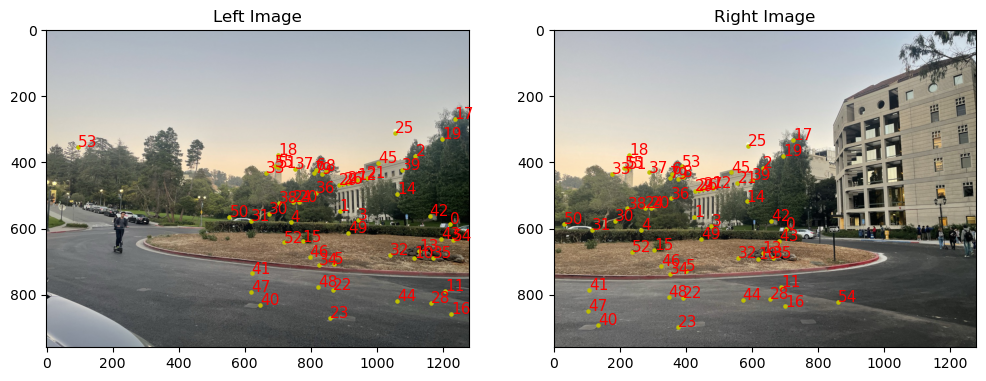

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    # ax[0].axis('off')
    # ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()